#  Car Safety Evaluation Using Desicion Trees
### Daniyal Mehraeen

### Part a)

In [1]:
import pandas as pd
import numpy as np
import math

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv("./car_evaluation.csv", index_col=0)
data.head()

,buying,maintenance cost,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [3]:
# Determining unique value counts for each feature
unique_counts = data.nunique()

# Identifing categorical and numerical features
categorical_columns = []
numerical_columns = []

for feature in unique_counts.index:
    if unique_counts[feature] <= 10:
        categorical_columns.append(feature)
    else:
        numerical_columns.append(feature)

print(categorical_columns)

['buying', 'maintenance cost', 'doors', 'persons', 'lug_boot', 'safety', 'class']


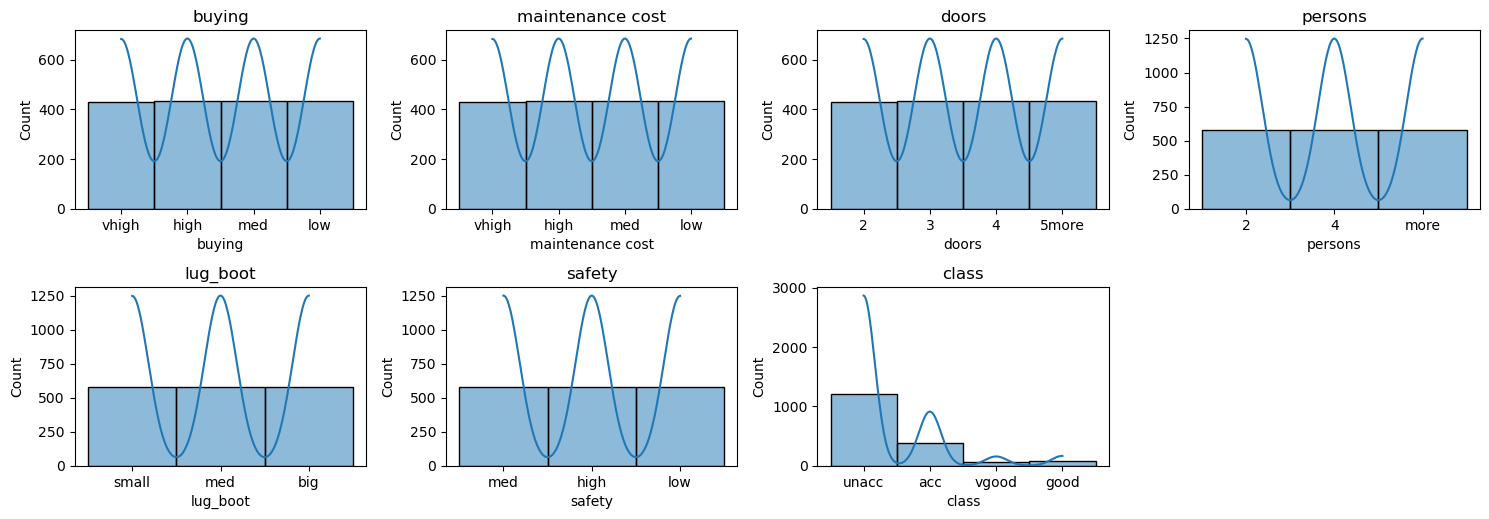

In [4]:
fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(15, 10))
axs = axs.flatten()

for i, column in enumerate(categorical_columns):
    plt.subplot(4, 4, i+1)
    sns.histplot(data=data, x=column, kde=True)
    axs[i].set_title(column)

# Removing empty subplots
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

### Part b)

In [5]:
data.isna().sum()

buying              0
maintenance cost    0
doors               0
persons             0
lug_boot            0
safety              0
class               0
dtype: int64

### Part c)

In [6]:
def entropy(data):

    target_col = data.iloc[:, -1]
    # Getting the unique classes and their counts
    classes, class_counts = np.unique(target_col, return_counts=True)
    entropy_val = 0
    
    # Calculating the entropy
    for count in class_counts:
        prob = count / len(target_col)
        entropy_val -= prob * math.log2(prob)
    
    return entropy_val

In [7]:
def information_gain(data, feature):
    target_col = data.iloc[:, -1]
    features = data[feature]
    
    unique_vals = features.unique()
    gain = entropy(data)
    
    # Calculating the information gain
    for val in unique_vals:
        subset = data[data[feature] == val]
        subset_entropy = entropy(subset)
        subset_prob = len(subset) / len(data)
        gain -= subset_prob * subset_entropy
    
    return gain

In [8]:
def create_decision_tree(data):
    # Base case: If there is only one column (the target column), return the majority class
    if data.shape[1] == 1:
        return data.iloc[0, -1]
    
    # Finding the best feature to split on based on information gain
    best_feature = max(data.columns[:-1], key=lambda feature: information_gain(data, feature))
    tree = {best_feature: {}}
    
    # Creating branches for each unique value of the best feature
    unique_vals = data[best_feature].unique()
    for val in unique_vals:
        # Creating a subset of data for the current value of the best feature
        subset = data[data[best_feature] == val].drop(best_feature, axis=1)
        # Recursively building the subtree
        tree[best_feature][val] = create_decision_tree(subset)
    
    return tree

In [9]:
def predict(sample, tree):
    labels = data["class"].unique()
    value_counts = data["class"].value_counts()
    probabilities = value_counts / len(data["class"])

    if isinstance(tree, str):  # leaf node
        return tree

    feature = next(iter(tree))  # Get the feature at the current node
    
    if feature in sample:
        if sample[feature] in tree[feature]:
            next_node = tree[feature][sample[feature]]
        else:
            # Handling missing feature values
            return np.random.choice(probabilities.index, p=probabilities.values)
    else:
        # Handling unknown features
        return "Unknown Feature"

    return predict(sample, next_node)

In [10]:
def classify_data(X, tree):
    predictions = []

    for i, row in X.iterrows():
        prediction = predict(row,tree)
        predictions.append(prediction)

    return predictions


In [11]:
# Splitting data into Train / Test sets
train_data, test_data = train_test_split(data,test_size=0.2,random_state=42)

X_train, y_train = train_data.iloc[:,:-1], train_data.iloc[:,-1]
X_test, y_test = test_data.iloc[:,:-1], test_data.iloc[:,-1]

In [12]:
tree = create_decision_tree(pd.concat([X_train,y_train],axis=1))

In [13]:
y_pred_test = classify_data(X_test,tree)

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred_test)
print(f"Accuracy: {accuracy*100}%")

Accuracy: 52.312138728323696%


In [14]:
def get_max_depth(dictionary):
    if not isinstance(dictionary, dict) or not dictionary:
        return 0

    max_depth = 0
    for value in dictionary.values():
        if isinstance(value, dict):
            depth = get_max_depth(value)
            max_depth = max(max_depth, depth)

    return max_depth + 1

In [15]:
print(f"Max depth of implemented tree: {get_max_depth(tree)}")

Max depth of implemented tree: 12


In [16]:
def confusion_matrix(y_true, y_pred, labels):
    num_labels = len(labels)
    print(labels)

    # Initializing the confusion matrix as a 2D array
    cm = np.zeros((num_labels, num_labels), dtype=int)

    # Craeting the confusion matrix
    for true, pred in zip(y_true, y_pred):
        true_idx = labels.index(true)
        pred_idx = labels.index(pred)
        cm[true_idx, pred_idx] += 1

    return cm


In [17]:
labels = data["class"].unique().tolist()
cm = confusion_matrix(y_pred=y_pred_test, y_true=y_test, labels=labels)

print("Confusion Matrix:")
print("\t\tPredicted labels")
print("\t\t", end="")
for label in labels:
    print(label, end="\t")
print()
print("True labels")
for idx, label in enumerate(labels):
    print(label, end="\t")
    for count in cm[idx]:
        print(count, end="\t")
    print()

['unacc', 'acc', 'vgood', 'good']
Confusion Matrix:
		Predicted labels
		unacc	acc	vgood	good	
True labels
unacc	157	63	9	8	
acc	47	24	3	3	
vgood	11	5	0	1	
good	9	5	1	0	


### Part d)

In [18]:
def create_decision_tree_with_pruning(data, pruning_threshold=0.1, max_depth=None):
    # Base case: If there is only one column (the target column), return the majority class
    if data.shape[1] == 1:
        return data.iloc[0, -1]
    
    # Finding the best feature to split on based on information gain
    best_feature = max(data.columns[:-1], key=lambda feature: information_gain(data, feature))
    tree = {best_feature: {}}
    
    # Creating branches for each unique value of the best feature
    unique_vals = data[best_feature].unique()
    for val in unique_vals:
        # Creating a subset of data for the current value of the best feature
        subset = data[data[best_feature] == val]
        
        # Checking if the subset is pure (contains only one class)
        unique_classes = subset.iloc[:, -1].unique()
        if len(unique_classes) == 1:
            tree[best_feature][val] = unique_classes[0]  # Assign the class label directly
        else:
            # Calculate the information gain for the subset
            subset_gain = information_gain(subset, best_feature)
            
            # Checking if the information gain is above the pruning threshold
            if subset_gain >= pruning_threshold and (max_depth is None or max_depth-1>=0):
                subset = subset.drop(best_feature, axis=1)  # Drop the best feature column from the subset
                # Recursively building the subtree
                tree[best_feature][val] = create_decision_tree(subset, pruning_threshold, max_depth-1)
            else:
                # Pruning the subtree and assigning the majority class as the label
                class_counts = subset.iloc[:, -1].value_counts()
                majority_class = class_counts.idxmax()
                tree[best_feature][val] = majority_class
    
    return tree

In [19]:
pruned_tree = create_decision_tree_with_pruning(pd.concat([X_train,y_train],axis=1))

In [20]:
y_pred_test = classify_data(X_test,pruned_tree)

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred_test)
print(f"Accuracy: {accuracy*100}%")

Accuracy: 68.4971098265896%


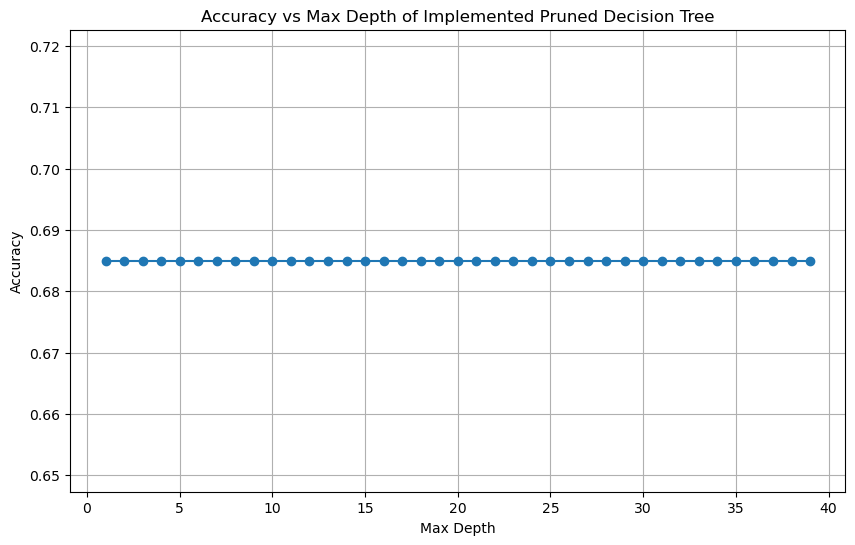

In [21]:
# Initializing lists to store max depths and accuracies
max_depths = []
accuracies = []

# Testing different max depths for the decision tree
for max_depth in range(1, 40):
    # Applying pruning by setting ccp_alpha parameter
    ccp_alpha = 0.01
    
    pruned_tree = create_decision_tree_with_pruning(pd.concat([X_train,y_train],axis=1), max_depth=max_depth)

    # Making predictions on the test set using the pruned classifier
    y_pred_pruned = classify_data(X_test, pruned_tree)

    # Calculating the accuracy of the classifier
    accuracy = accuracy_score(y_test, y_pred_pruned)

    # Appending max depth and accuracy to the lists
    max_depths.append(max_depth)
    accuracies.append(accuracy)

# Plot the line chart
plt.figure(figsize=(10,6))

plt.plot(max_depths, accuracies, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth of Implemented Pruned Decision Tree')
plt.grid(True)
plt.show()

### Part e)

In [22]:
# Converting String Values into Numerical as sklearn Desicion Tree Classifier only accpets numeric values
string_columns = data.select_dtypes(include=['object']).columns

# Initializing LabelEncoder
label_encoder = LabelEncoder()

# Converting categorical columns to numerical values
for column in string_columns:
    data[column] = label_encoder.fit_transform(data[column])

data.head()

,buying,maintenance cost,doors,persons,lug_boot,safety,class
0,3,3,0,0,2,2,2
1,3,3,0,0,2,0,2
2,3,3,0,0,1,1,2
3,3,3,0,0,1,2,2
4,3,3,0,0,1,0,2


In [23]:
# Splitting data into Train / Test sets
train_data, test_data = train_test_split(data,test_size=0.2,random_state=42)

X_train, y_train = train_data.iloc[:,:-1], train_data.iloc[:,-1]
X_test, y_test = test_data.iloc[:,:-1], test_data.iloc[:,-1]

In [24]:
# Creating a decision tree classifier
clf = DecisionTreeClassifier(random_state=42)

# Training the classifier using the training data
clf.fit(X_train, y_train)

# Prediciting labels on the test data
y_pred_clf = clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_clf)
print(f"Accuracy before pruning: {accuracy*100}%")

Accuracy before pruning: 97.10982658959537%


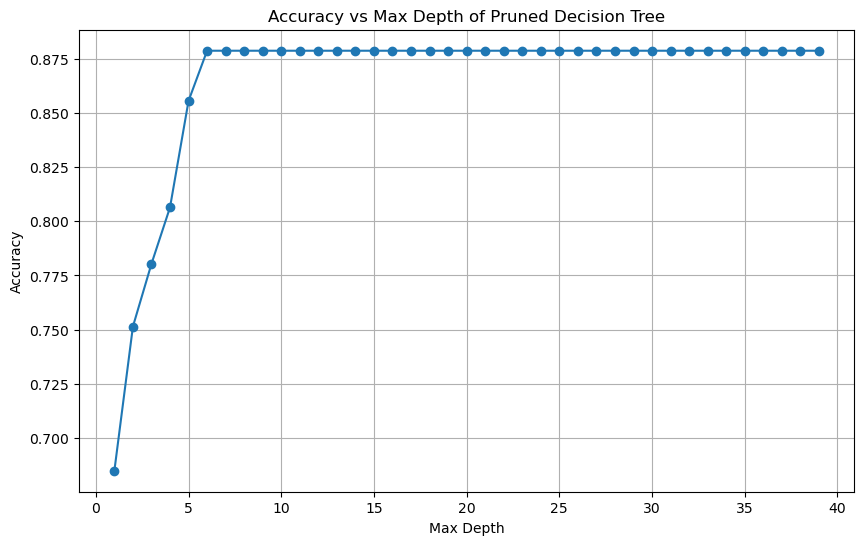

In [25]:

# Initialize lists to store max depths and accuracies
max_depths = []
accuracies = []

# Test different max depths for the decision tree
for max_depth in range(1, 40):
    # Apply pruning by setting ccp_alpha parameter
    ccp_alpha = 0.01
    
    pruned_classifier = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha, max_depth=max_depth)

    # Train the pruned decision tree classifier
    pruned_classifier.fit(X_train, y_train)

    # Make predictions on the test set using the pruned classifier
    y_pred_pruned = pruned_classifier.predict(X_test)

    # Calculate the accuracy of the classifier
    accuracy = accuracy_score(y_test, y_pred_pruned)

    # Append max depth and accuracy to the lists
    max_depths.append(max_depth)
    accuracies.append(accuracy)

# Plot the line chart
plt.figure(figsize=(10,6))

plt.plot(max_depths, accuracies, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth of Pruned Decision Tree')
plt.grid(True)
plt.show()


In [26]:
print(f"Max Accuracy for prunned decision tree is {np.max(accuracies)*100}% with max_depth = {np.argmax(accuracies)+1}")

Max Accuracy for prunned decision tree is 87.86127167630057% with max_depth = 6
